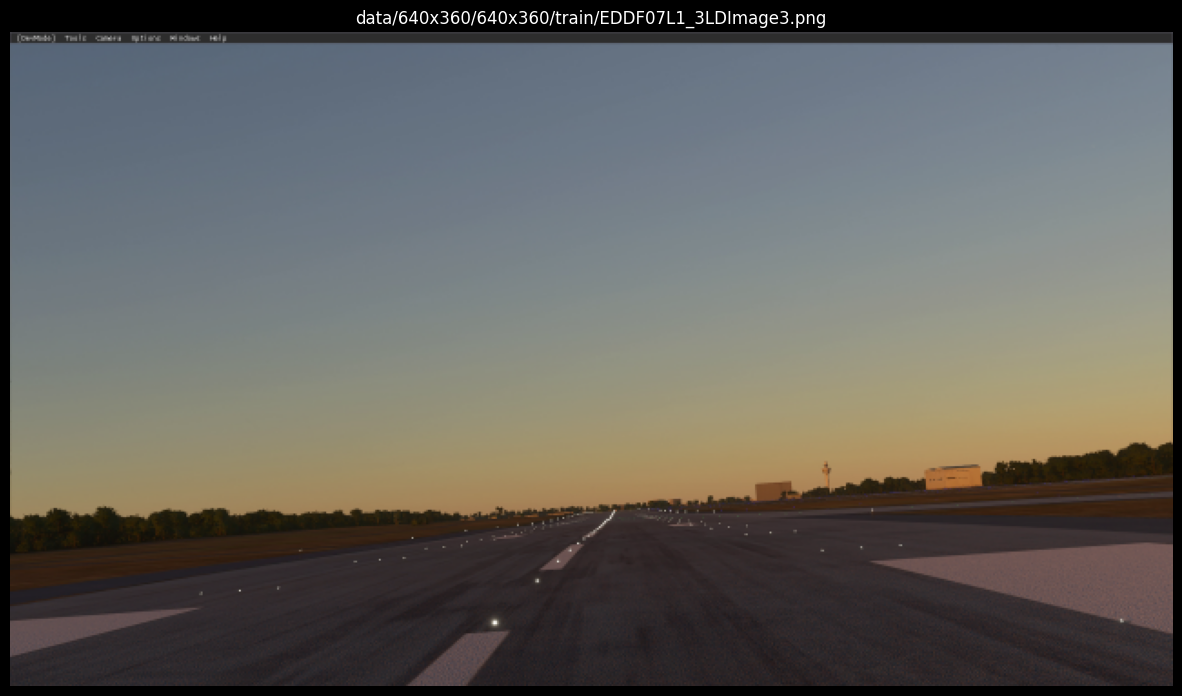

In [25]:
#Look at images
from pathlib import Path
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from mpmath.identification import transforms
from torchvision.ops.misc import interpolate

random.seed(42)
LOCALPATH = Path('data/1920x1080/1920x1080')
KAGGLEPATH = Path('/kaggle/input/fs2020-runway-dataset/1920x1080/1920x1080')

if os.path.exists(KAGGLEPATH):
    target_dir_feature = KAGGLEPATH
else:
    target_dir_feature = LOCALPATH

if target_dir_feature.exists():
    train_dir = target_dir_feature/'train'
    test_dir = target_dir_feature/'test'
    image_path_feature_list = list(train_dir.glob('*.png'))

    if len(image_path_feature_list)>0:

        random_image_path = random.choice(image_path_feature_list)
        image = Image.open(random_image_path)

        plt.figure(figsize=(15,15))
        plt.imshow(image)
        plt.title(random_image_path)
        plt.axis('off')
        plt.show()

    else:
        print(f'No images found in  {train_dir}')

else:
    print('Directory not found')

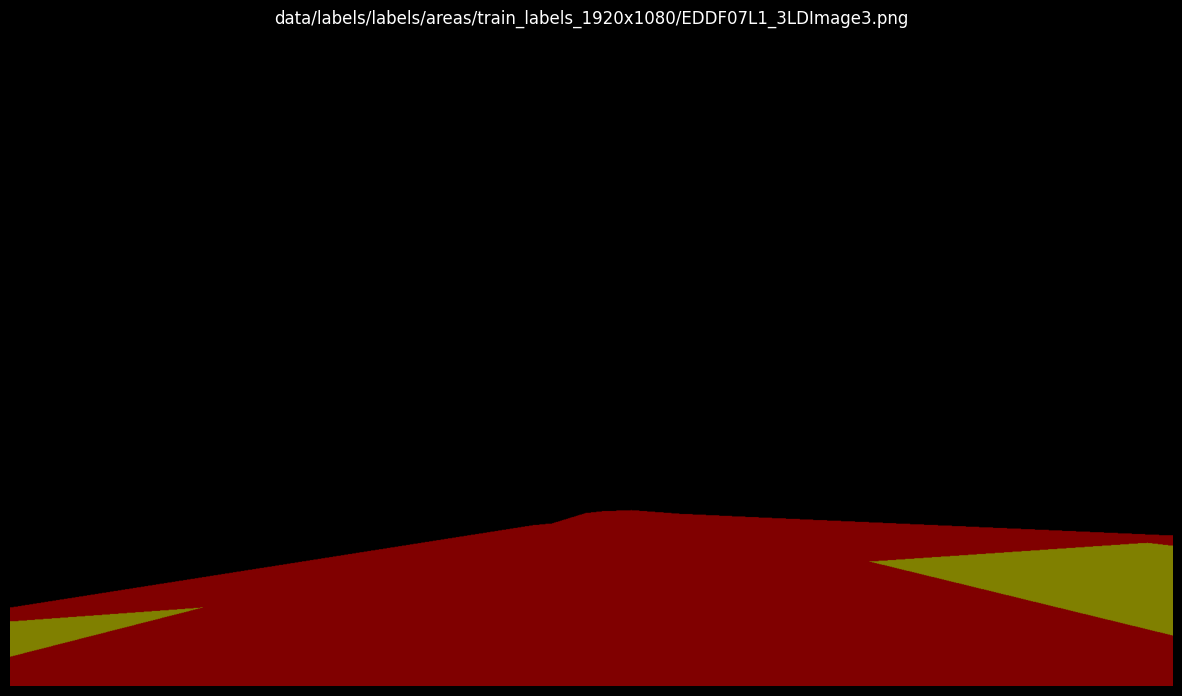

In [26]:
#look at the label masks
LOACLPATHMASKS = Path('data/labels/labels/areas/')
KAGGLEPATHMASKS = Path('/kaggle/input/fs2020-runway-dataset/labels/labels/areas/')
random.seed(42)

if os.path.exists(KAGGLEPATHMASKS):
    target_dir_masks = KAGGLEPATHMASKS
else:
    target_dir_masks = LOACLPATHMASKS

if target_dir_masks.exists():
    train_masks_dir = target_dir_masks/'train_labels_1920x1080/'
    test_masks_dir = target_dir_masks/'test_labels_1920x1080/'

    image_mask_list = list(train_masks_dir.glob('*.png'))
    if len(image_mask_list)>0:
        random_image_mask_path = random.choice(image_mask_list)
        image_mask = Image.open(random_image_mask_path)

        plt.figure(figsize=(15,15))
        plt.imshow(image_mask)
        plt.title(random_image_mask_path)
        plt.axis('off')
        plt.show()

    else:
        print(f'No images found in  {train_dir_labels}')
else:
    print('Directory not found')

In [27]:
#set device agnostics
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [28]:
#TRransforms images as well masks
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(brightness=[max(0, 1 - 0.2), 1 + 0.2],
                           contrast=[max(0, 1 - 0.2), 1 + 0.2],
                           saturation=[max(0, 1 - 0.2), 1 + 0.2],
                           hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),

])

mask_transform = transforms.Compose([
    transforms.Resize(256,interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.8033988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2727973].


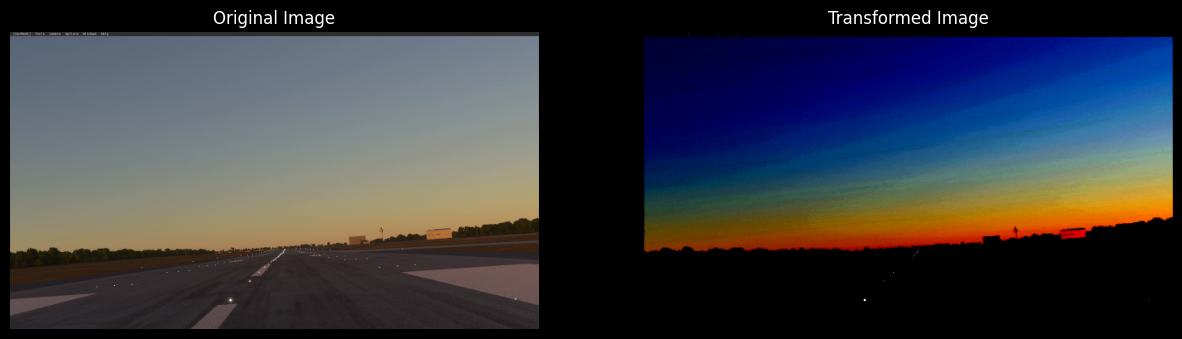

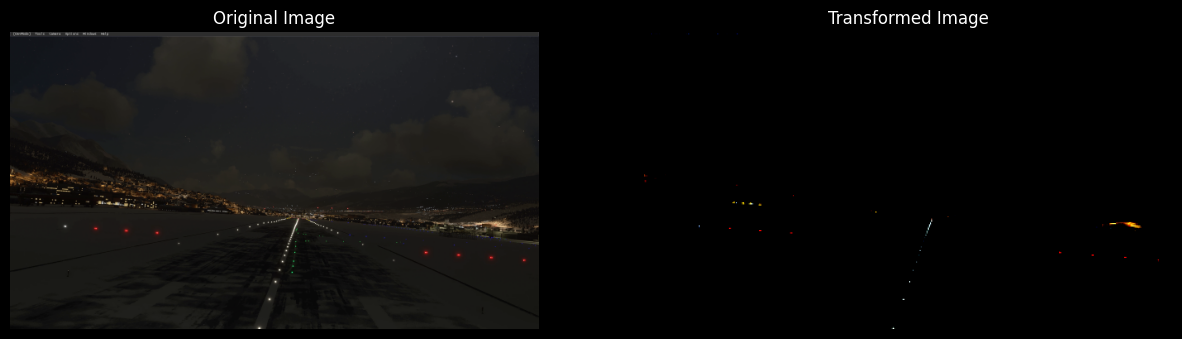

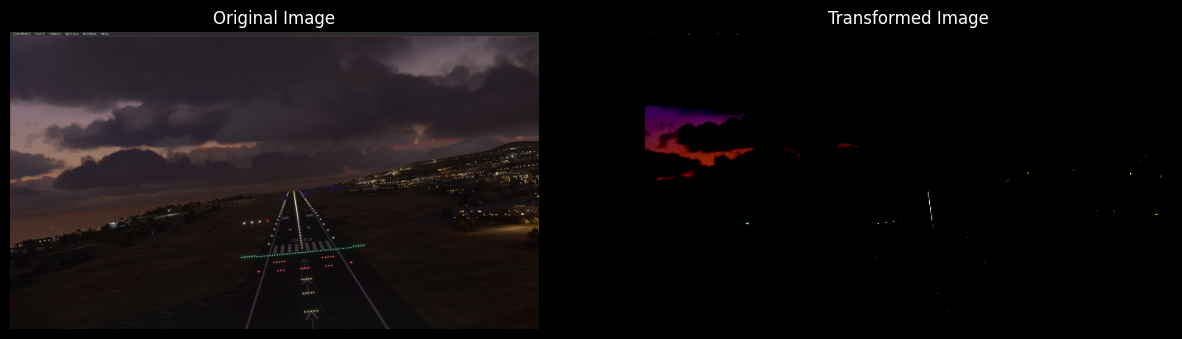

In [29]:
#View Transformed images
random.seed(42)

random_image_path = random.sample(image_path_feature_list,3)

for image_path in random_image_path:
    with Image.open(image_path) as img:
        fig,ax = plt.subplots(1,2, figsize=(15,15))

        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        transformed_img = image_transform(img).permute(1, 2, 0)

        ax[1].imshow(transformed_img)
        ax[1].set_title('Transformed Image')
        ax[1].axis('off')

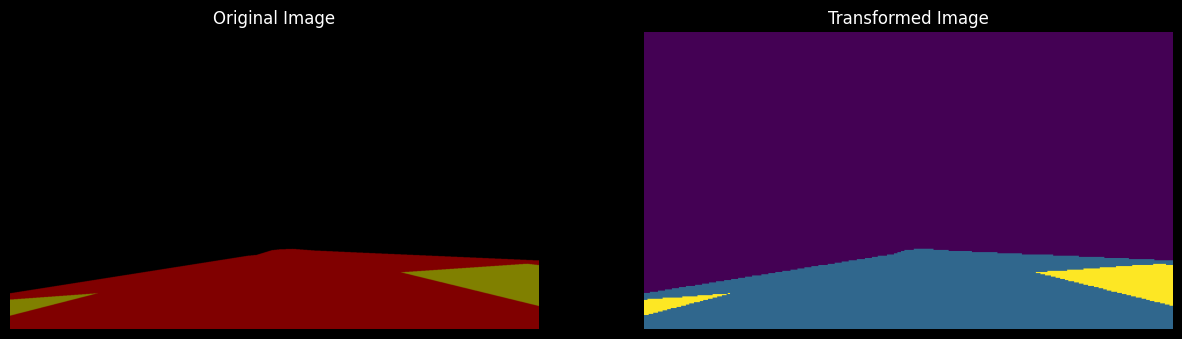

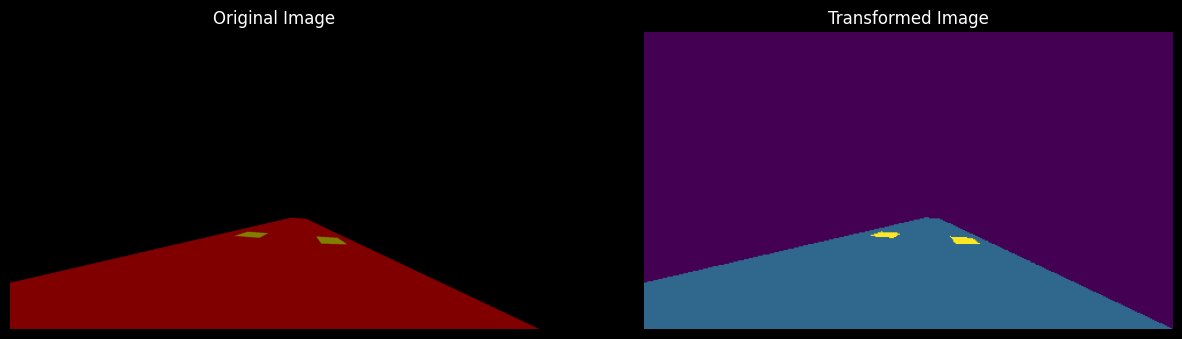

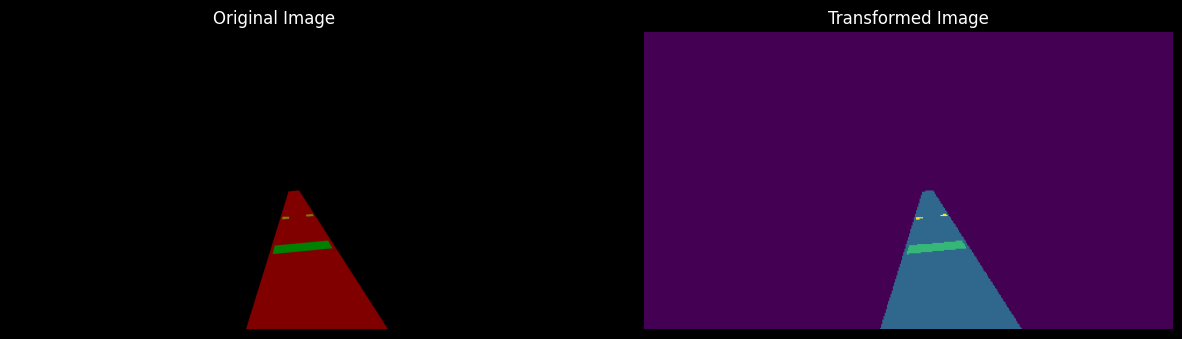

In [30]:
#View Transformed labels
random.seed(42)

random_mask_path = random.sample(image_mask_list,3)

for image_path in random_mask_path:
    with Image.open(image_path) as img:
        fig,ax = plt.subplots(1,2, figsize=(15,15))

        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        transformed_img = mask_transform(img).permute(1, 2, 0)

        ax[1].imshow(transformed_img)
        ax[1].set_title('Transformed Image')
        ax[1].axis('off')

In [35]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image

class RunwayDataset(Dataset):
    def __init__(self, train_dir,mask_dir, image_transform=None, mask_transform=None):
        self.train_dir = Path(train_dir)
        self.image_transform = image_transform
        self.mask_dir = Path(mask_dir)
        self.mask_transform = mask_transform


        self.image_paths = sorted(list(self.train_dir.glob("*.jpg")) + list(self.train_dir.glob("*.png")))


        self.mask_paths = sorted(list(self.mask_dir.glob("*.png")))


        if len(self.image_paths) != len(self.mask_paths):
            print(f"⚠️ Warning: Found {len(self.image_paths)} images but {len(self.mask_paths)} masks!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path)

        mask = Image.open(mask_path).convert("L")


        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [36]:
train_dataset = RunwayDataset(
    train_dir = train_dir,
    mask_dir = train_masks_dir,
    image_transform = image_transform,
    mask_transform= mask_transform
)

test_dataset = RunwayDataset(
    train_dir =test_dir,
    mask_dir = test_masks_dir,
    image_transform = image_transform,
    mask_transform= mask_transform
)
train_dataset.__getitem__(1)

(tensor([[[-1.1247, -1.1932, -1.1760,  ..., -1.1932, -1.1932, -1.1247],
          [-1.2274, -1.3644, -1.1932,  ..., -1.3644, -1.3644, -1.2274],
          [-1.2274, -1.3644, -1.1247,  ..., -1.3644, -1.3644, -1.2274],
          ...,
          [ 0.3138,  0.2796,  0.2967,  ...,  0.2282,  0.2111,  0.2282],
          [ 0.2967,  0.2796,  0.2796,  ...,  0.1426,  0.1254,  0.2111],
          [ 0.1426,  0.2624,  0.3138,  ..., -0.0629, -0.0629,  0.0912]],
 
         [[-1.0378, -1.1078, -1.0903,  ..., -1.1078, -1.0903, -1.0203],
          [-1.1429, -1.2654, -1.0903,  ..., -1.2654, -1.2654, -1.1429],
          [-1.1429, -1.2654, -1.0203,  ..., -1.2654, -1.2654, -1.1429],
          ...,
          [ 0.0826,  0.0651,  0.0651,  ...,  0.0476,  0.0301,  0.0476],
          [ 0.0476,  0.0651,  0.0651,  ..., -0.0049, -0.0049,  0.0476],
          [-0.0049,  0.0651,  0.0826,  ..., -0.1450, -0.1450, -0.0049]],
 
         [[-0.7064, -0.8633, -0.8284,  ..., -0.8458, -0.8458, -0.7238],
          [-0.8981, -1.0550,